In [1]:
#imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

import plotly.express as px

import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

## data preprocessing

In [2]:
patientdata = pd.read_csv('../input/lgg-mri-segmentation/kaggle_3m/data.csv')
patientdata.info()
         
age_counts = patientdata["age_at_initial_pathologic"].value_counts()
fig = px.bar(age_counts, title="Age of patients")
fig.update_layout(
    xaxis_title = "Age",
    yaxis_title = "Frequency",
    title_x = 0.5, 
    showlegend = False
)
fig.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [3]:
patientdata.head()

Patient  RNASeqCluster  MethylationCluster  miRNACluster  CNCluster  \
0  TCGA_CS_4941            2.0                 4.0             2        2.0   
1  TCGA_CS_4942            1.0                 5.0             2        1.0   
2  TCGA_CS_4943            1.0                 5.0             2        1.0   
3  TCGA_CS_4944            NaN                 5.0             2        1.0   
4  TCGA_CS_5393            4.0                 5.0             2        1.0   

   RPPACluster  OncosignCluster  COCCluster  histological_type  \
0          NaN              3.0           2                1.0   
1          1.0              2.0           1                1.0   
2          2.0              2.0           1                1.0   
3          2.0              1.0           1                1.0   
4          2.0              3.0           1                1.0   

   neoplasm_histologic_grade  tumor_tissue_site  laterality  tumor_location  \
0                        2.0                1.0         3.0             2.0   
1                        2.0                1.0         3.0             2.0   
2                        2.0                1.0         1.0             2.0   
3                        1.0                1.0         3.0             6.0   
4                        2.0                1.0         1.0             6.0   

   gender  age_at_initial_pathologic  race  ethnicity  death01  
0     2.0                       67.0   3.0        2.0      1.0  
1     1.0                       44.0   2.0        NaN      1.0  
2     2.0                       37.0   3.0        NaN      0.0  
3     2.0                       50.0   3.0        NaN      0.0  
4     2.0                       39.0   3.0        NaN      0.0

In [4]:
# Make objects with the images and masks. 
brain_scans = []
mask_files = glob.glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    brain_scans.append(i.replace('_mask',''))

print(brain_scans[:10])
print(mask_files[:10])

['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_43.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_39.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_7.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_31.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_6.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_38.tif']
['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_1986030

In [5]:
# Make a dataframe with the images and their corresponding masks
data_img = pd.DataFrame({
    "image_path":brain_scans,
    "mask_path":mask_files
})

In [6]:
# Make a function that search for the largest pixel value in the masks, because that will indicate if the image have 
# a corresponding mask with a tumor or not. 
def positive_negative_diagnosis(file_masks):
    mask = cv2.imread(file_masks)
    value = np.max(mask)
    if value > 0:
        return 1
    else:
        return 0
    
# Apply the function to the masks and return back a column with 1 and zeros, where 0 indicate no tumor and 1 a tumor. 
data_img["Tumor"] = data_img["mask_path"].apply(lambda x: positive_negative_diagnosis(x)) 

In [7]:
data_img 

image_path  \
0     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
1     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
2     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
4     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
...                                                 ...   
3924  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3925  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3926  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3927  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3928  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   

                                              mask_path  Tumor  
0     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...      0  
1     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...      0  
2     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...      1  
3     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...      1  
4     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...      1  
...                                                 ...    ...  
3924  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...      0  
3925  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...      0  
3926  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...      0  
3927  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...      0  
3928  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...      0  

[3929 rows x 3 columns]

In [8]:
data_img['Tumor'].value_counts()

0    2556
1    1373
Name: Tumor, dtype: int64

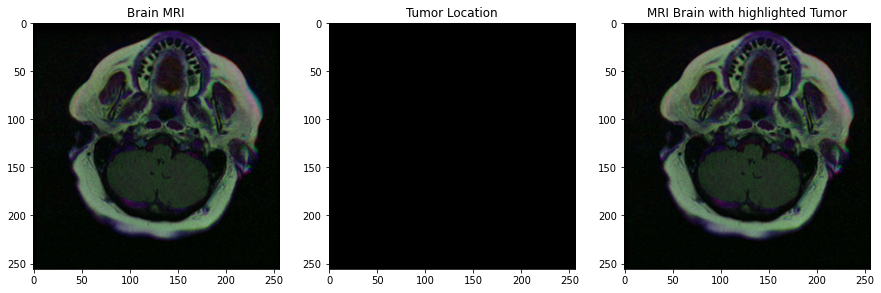

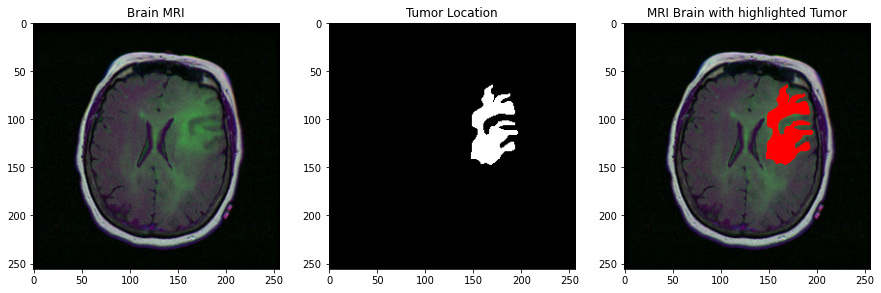

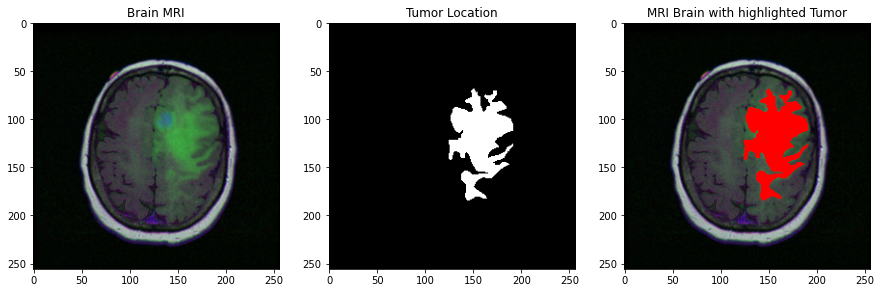

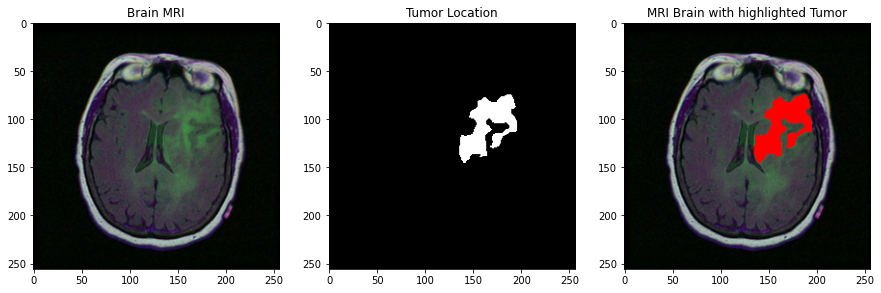

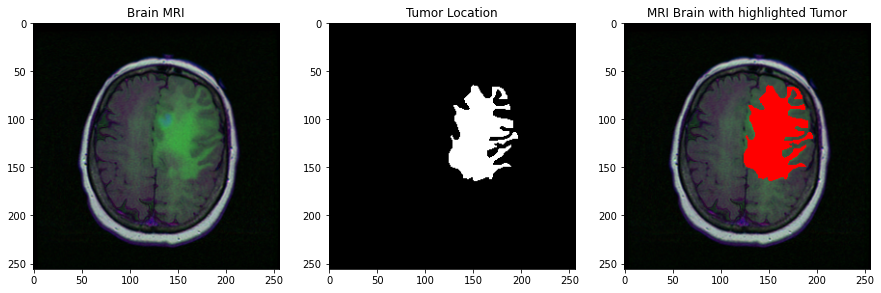

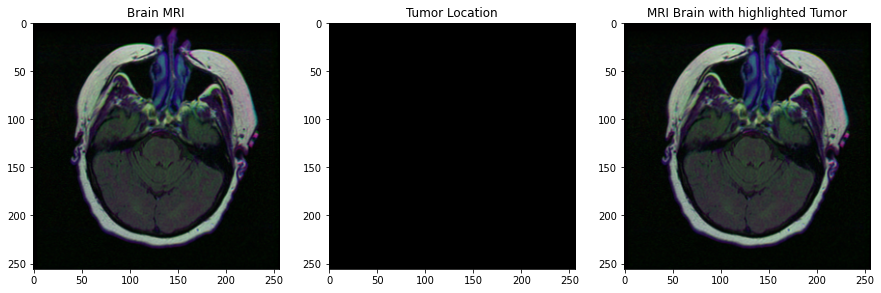

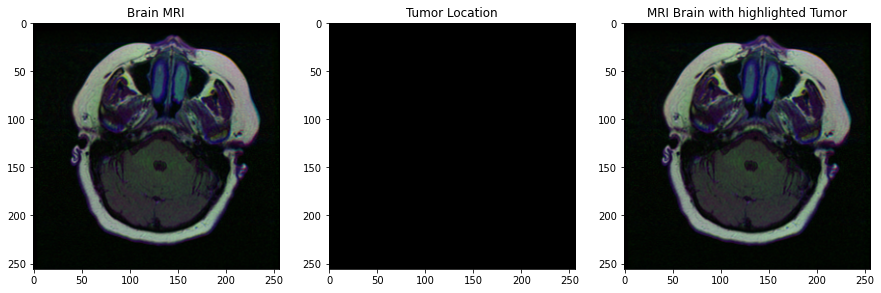

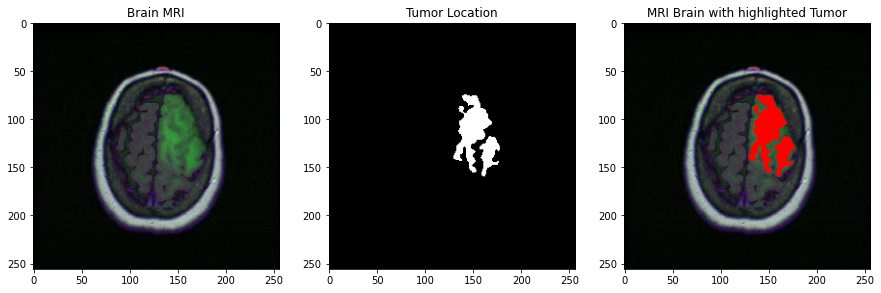

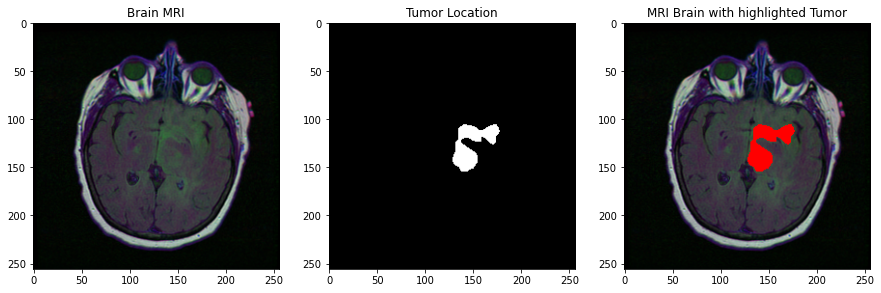

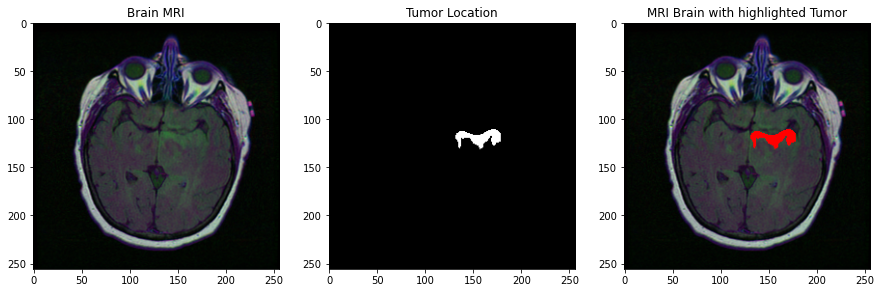

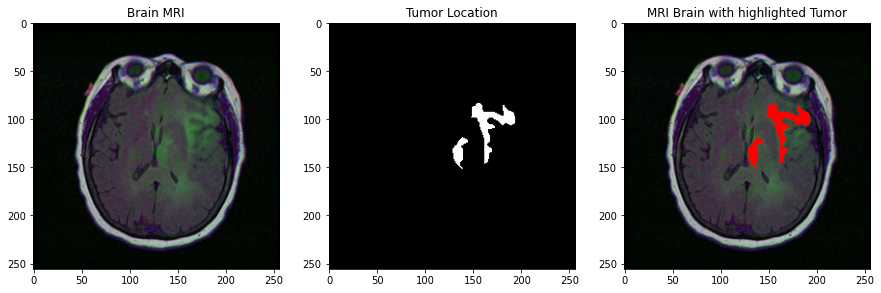

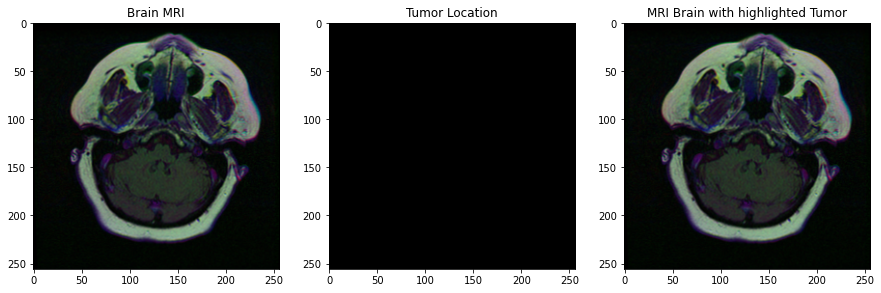

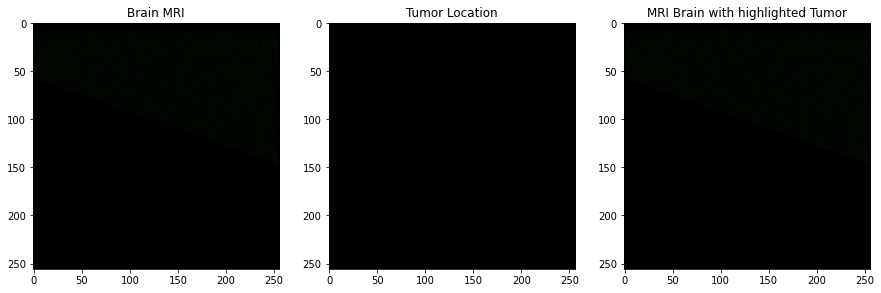

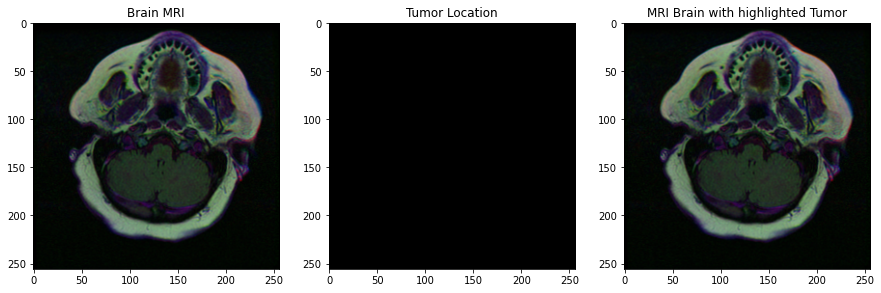

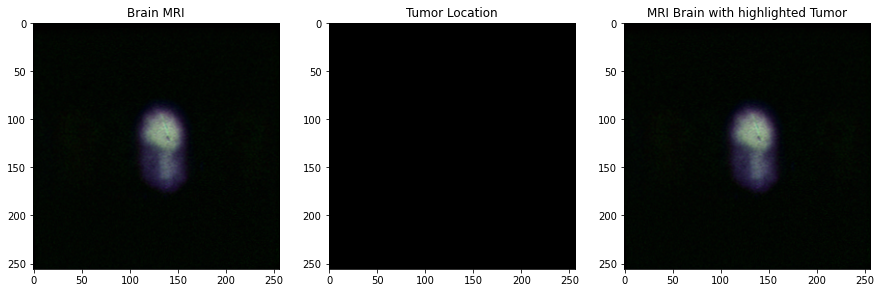

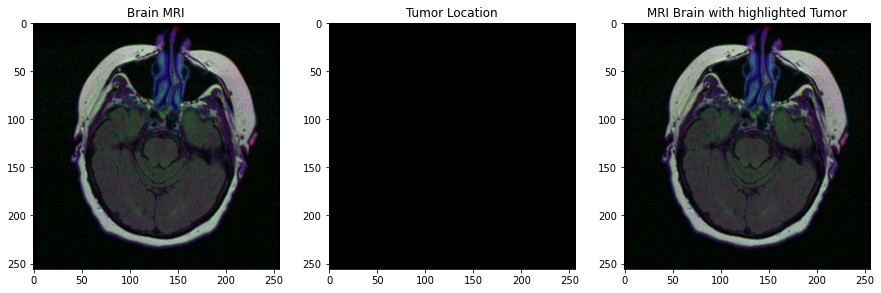

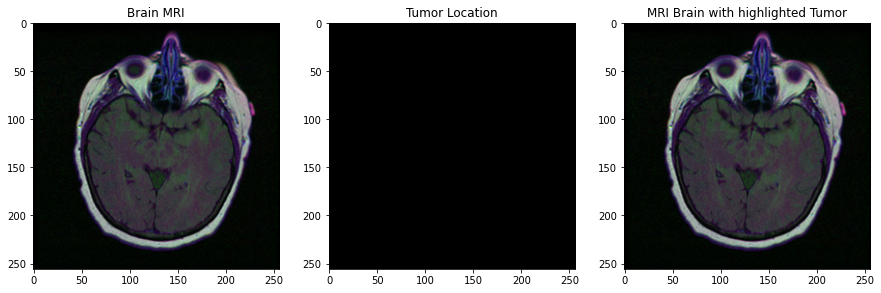

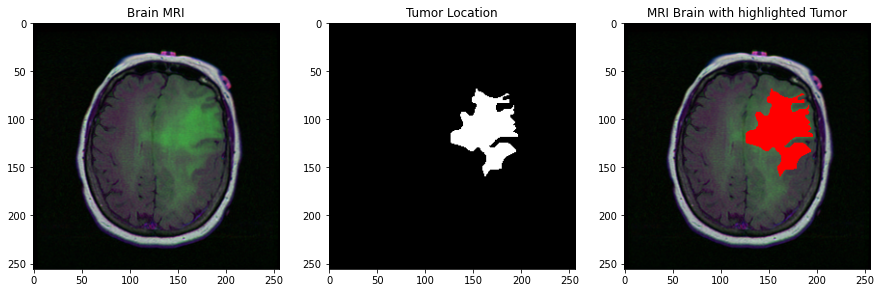

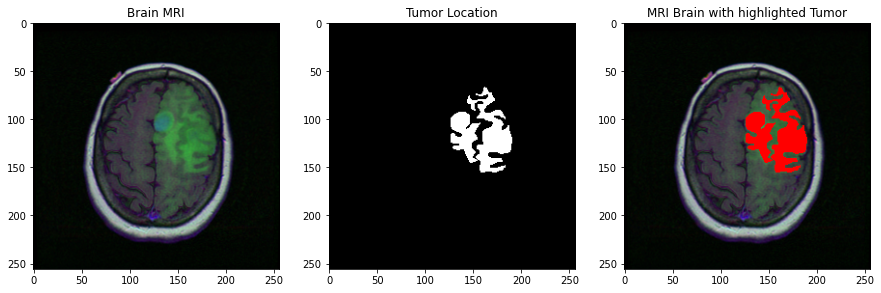

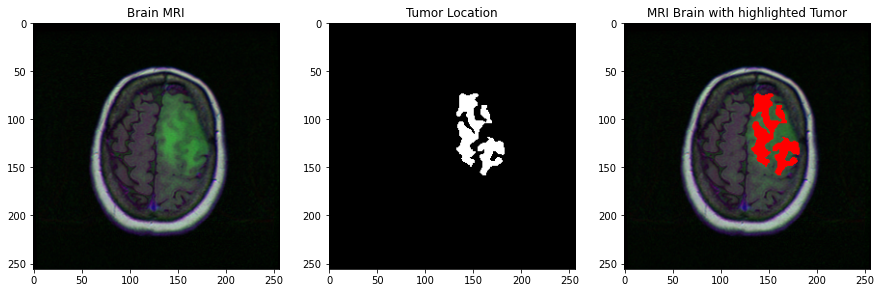

In [9]:
# visualisation
for i in range(1,40, 2):
    img_path=brain_scans[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)

    #Plot the Brain MRI scans 
    original = img.copy()
    fig, ax = plt.subplots(1,3,figsize = (15,5))
    ax[0].imshow(original)
    ax[0].set_title("Brain MRI")
   
    # Plot the corresponding mask
    main = original.copy()
    mask = msk.copy()
    ax[1].imshow(mask)
    ax[1].set_title("Tumor Location")

    # Plot the Brain MRI scan with their mask
    main = original.copy()
    label = cv2.imread(msk_path)
    sample = np.array(np.squeeze(label), dtype = np.uint8)
    contours, hier = cv2.findContours(sample[:,:,0],cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    sample_over_gt = cv2.drawContours(main, contours, -1,[255,0,0], thickness=-1)
    ax[2].imshow(sample_over_gt)
    ax[2].set_title("MRI Brain with highlighted Tumor")

In [10]:
data_img['Tumor'] = data_img['Tumor'].apply(lambda x: str(x))
data_img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   Tumor       3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_img,test_size = 0.1)
train, val = train_test_split(train,test_size = 0.2)
print(train.values.shape)
print(val.values.shape)
print(test.values.shape)

train.head()
val.head()

(2828, 3)
(708, 3)
(393, 3)


image_path  \
560   ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3026  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_F...   
2252  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
3176  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
2932  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...   

                                              mask_path Tumor  
560   ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     1  
3026  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_F...     1  
2252  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...     0  
3176  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     0  
2932  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...     1

In [12]:

import plotly.graph_objects as go  


fig = go.Figure([go.Bar(x=train['Tumor'].value_counts().index, 
                        y=train['Tumor'].value_counts(), 
                        width=[.4, .4],
                       )
                ])
fig.update_traces(marker_color=['darkolivegreen', 'firebrick'], opacity = 0.7
                 )

fig.update_layout(title_text="Tumor Count Train Set",
                  width=700,
                  height=550,
                  yaxis=dict(
                             title_text="Count",
                             tickmode="array",
                             titlefont=dict(size=20)
                           )
                 )

fig.update_yaxes(range = list([0,2000]))
fig.update_xaxes(tick0 = 0, dtick = 1)

fig.show()

fig2 = go.Figure([go.Bar(x=val['Tumor'].value_counts().index, 
                        y=val['Tumor'].value_counts(), 
                        width=[.4, .4]
                       )
                ])
fig2.update_traces(marker_color=['darkolivegreen', 'firebrick'], opacity = 0.7
                 )
fig2.update_layout(title_text="Tumor Count Validation Set",
                  width=700,
                  height=550,
                  yaxis=dict(
                             title_text="Count",
                             tickmode="array",
                             titlefont=dict(size=20)
                           )
                 )

fig2.update_yaxes(range = list([0,2000]))
fig2.update_xaxes(tick0 = 0, dtick = 1)


fig2.show()

fig3 = go.Figure([go.Bar(x=test['Tumor'].value_counts().index, 
                        y=test['Tumor'].value_counts(), 
                        width=[.4, .4]
                       )
                ])
fig3.update_traces(marker_color=['darkolivegreen', 'firebrick'], opacity = 0.7
                 )
fig3.update_layout(title_text="Tumor Count Test Set",
                  width=700,
                  height=550,
                  yaxis=dict(
                             title_text="Count",
                             tickmode="array",
                             titlefont=dict(size=20)
                           )
                 )

fig3.update_yaxes(range = list([0,2000]))
fig3.update_xaxes(tick0 = 0, dtick = 1)

fig3.show()

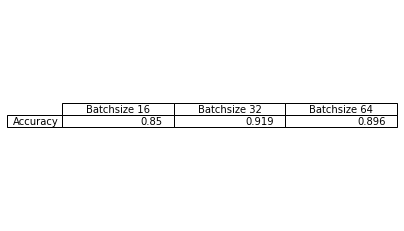

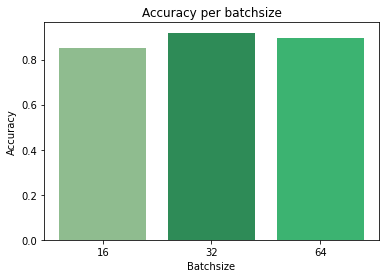

In [13]:
import numpy as np
import matplotlib.pyplot as plt

#Table
fig, ax =plt.subplots(1,1)
data=[[0.850, 0.919,  0.896]]
column_labels=['Batchsize 16', 'Batchsize 32', 'Batchsize 64']
row_label = ['Accuracy']
ax.axis('tight')
ax.axis('off')
ax.table(cellText=data,colLabels=column_labels,rowLabels=row_label, loc="center")

plt.show()

#Barplot
# Make a random dataset:
height = [0.850, 0.919, 0.896]
bars = ('16', '32', '64')
x_pos = np.arange(len(bars))

# Create bars and choose color
plt.bar(x_pos, height, color = ['darkseagreen', 'seagreen', 'mediumseagreen'])
 
# Add title and axis names
plt.title('Accuracy per batchsize')
plt.xlabel('Batchsize')
plt.ylabel('Accuracy')

# Create names on the x axis
plt.xticks(x_pos, bars)

# Show graph
plt.show()

In [14]:

from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates


def elastic_transform(image, alpha_range, sigma, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)
        
    if np.isscalar(alpha_range):
        alpha = alpha_range
    else:
        alpha = np.random.uniform(low=alpha_range[0], high=alpha_range[1])

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1)), np.reshape(z, (-1, 1))
    
    transformed_images = map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

    return transformed_images

### Visualising the tuning

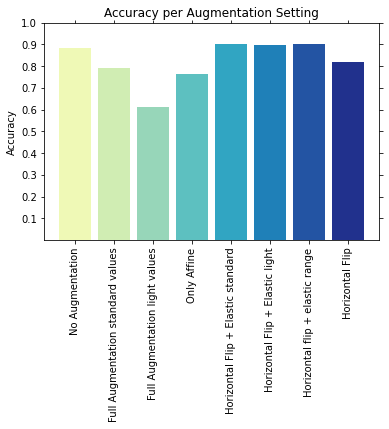

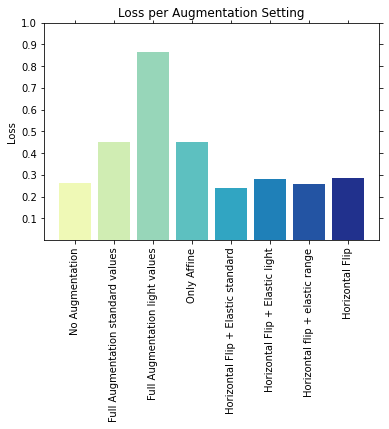

In [15]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

height = [0.8830, 0.7917, 0.6132, 0.7631, 0.9005, 0.8957, 0.9008, 0.8193]
bars = ('No Augmentation', 'Full Augmentation standard values', 'Full Augmentation light values', 'Only Affine',
        'Horizontal Flip + Elastic standard', 'Horizontal Flip + Elastic light', 'Horizontal flip + elastic range',
        'Horizontal Flip'
       )

x_pos = np.arange(len(bars))

colours = sns.color_palette("YlGnBu", 8)

plt.bar(x_pos, height, color = colours)
 
# Add title and axis names
plt.title('Accuracy per Augmentation Setting')
plt.ylabel('Accuracy')

# Create names on the x axis
plt.yticks((0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0))
plt.xticks(x_pos, bars, rotation = 90)
plt.tick_params(top='off', bottom='on', left='on', right='off', labelleft='on', labelbottom='on')

# Show graph
plt.show()

# Accuracies:
height = [0.2641, 0.4504, 0.8652, 0.4492, 0.2381, 0.2797, 0.2563, 0.2848]
bars = ('No Augmentation', 'Full Augmentation standard values', 'Full Augmentation light values', 'Only Affine',
        'Horizontal Flip + Elastic standard', 'Horizontal Flip + Elastic light', 'Horizontal flip + elastic range',
        'Horizontal Flip'
       )

colours = sns.color_palette("YlGnBu", 8)

# Create bars and choose color
plt.bar(x_pos, height, color = colours)
 
# Add title and axis names
plt.title('Loss per Augmentation Setting')
plt.ylabel('Loss')

# Create names on the x axis
plt.yticks((0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0))
plt.xticks(x_pos, bars, rotation = 90)
plt.tick_params(top='off', bottom='on', left='on', right='off', labelleft='on', labelbottom='on')

# Show graph
plt.show()

### Adding the data augmentation to the image data generator

In [16]:
from keras_preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(rescale=1./255., 
                             validation_split=0.15,
                             horizontal_flip = True,
                             preprocessing_function = lambda x: elastic_transform(x, 
                                                                                 alpha_range =  [2,6],
                                                                                 sigma = 2.5)
                            )
                            

train_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='Tumor',
                                              subset='training',
                                              class_mode='binary',
                                              batch_size=32,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )

valid_generator = datagen.flow_from_dataframe(val,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='Tumor',
                                              subset='validation',
                                              class_mode='binary',
                                              batch_size=32,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )

test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='./',
                                                  x_col='image_path',
                                                  y_col='Tumor',
                                                  class_mode='binary',
                                                  batch_size=32,
                                                  shuffle=False,
                                                  target_size=(256,256)
                                                 )

Found 2404 validated image filenames belonging to 2 classes.
Found 106 validated image filenames belonging to 2 classes.
Found 393 validated image filenames belonging to 2 classes.


In [17]:
from tensorflow.keras.applications import VGG16

pretrained_base = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(256,256,3)))
pretrained_base.summary()  

pretrained_base.trainable = False

2021-12-23 13:43:42.526443: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 13:43:42.527529: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 13:43:42.528221: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 13:43:42.529031: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

In [18]:
from tensorflow.keras import layers

model = keras.Sequential([
    
    # Base
    pretrained_base,
    
    # Head
    layers.Flatten(name='Flatten'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])

In [19]:
model.compile(loss = 'binary_crossentropy', 
              optimizer='adam', 
              metrics= ['accuracy']
             )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
Flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2

In [20]:
earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta=0.001,
                              mode='min', 
                              verbose=1, 
                              patience=20,
                              restore_best_weights = True
                             )

checkpointer = ModelCheckpoint(filepath="vgg16_1.h5",
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_best_only=True
                              )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=15,
                              min_delta=0.0001,
                              factor=0.2
                             )

callbacks = [checkpointer, earlystopping, reduce_lr]

In [21]:
history = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 100, 
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size,
              callbacks=callbacks)

2021-12-23 13:43:48.946313: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2021-12-23 13:43:52.160485: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


75/75 [==============================] - 143s 2s/step - loss: 0.7421 - accuracy: 0.7146 - val_loss: 0.3401 - val_accuracy: 0.8542

Epoch 00001: val_accuracy improved from -inf to 0.85417, saving model to vgg16_1.h5
Epoch 2/100
75/75 [==============================] - 116s 2s/step - loss: 0.4295 - accuracy: 0.7749 - val_loss: 0.3108 - val_accuracy: 0.8750

Epoch 00002: val_accuracy improved from 0.85417 to 0.87500, saving model to vgg16_1.h5
Epoch 3/100
75/75 [==============================] - 116s 2s/step - loss: 0.4213 - accuracy: 0.7804 - val_loss: 0.3540 - val_accuracy: 0.8438

Epoch 00003: val_accuracy did not improve from 0.87500
Epoch 4/100
75/75 [==============================] - 116s 2s/step - loss: 0.4241 - accuracy: 0.7728 - val_loss: 0.4004 - val_accuracy: 0.8125

Epoch 00004: val_accuracy did not improve from 0.87500
Epoch 5/100
75/75 [==============================] - 116s 2s/step - loss: 0.4313 - accuracy: 0.7770 - val_loss: 0.3945 - val_accuracy: 0.8021

Epoch 00005: val

### Classification Model Evaluation

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

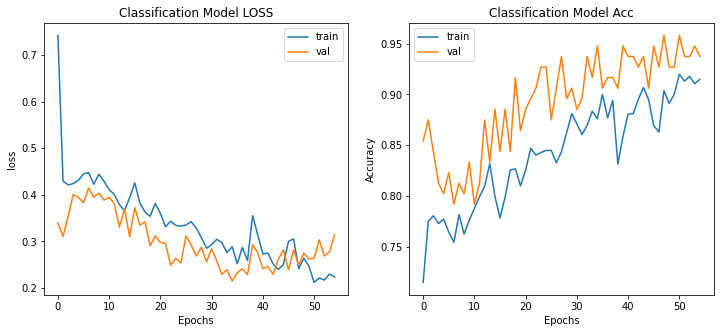

In [23]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(history.history['accuracy']);
plt.plot(history.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [24]:
_, acc = model.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

13/13 [==============================] - 5s 365ms/step - loss: 0.3023 - accuracy: 0.8931
Test accuracy : 89.31297659873962 %


In [25]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [26]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [27]:
def unet(input_size=(256,256,3)):
    
    # Input
    inputs = Input(input_size)
    
    # Stage 1 
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    # Stage 2
    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    # Stage 3
    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    # Stage 4
    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    # Stage 5
    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    # Upstage 1
    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    # Upstage 2
    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    # Upstage 3
    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    # Upstage 4
    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    # Output 
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [28]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       activation[0][0]                 
______________________________________________________________________________________________

In [29]:
EPOCHS = 100
BATCH_SIZE = 32
im_height = 256
im_width = 256

In [30]:
train_generator_args = dict(width_shift_range=0.05,
                            height_shift_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')


train_gen = train_generator(train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gener = train_generator(val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))

### Defining the callbacks

In [31]:
checkpointer2 = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]

callbacks = [checkpointer2, earlystopping, reduce_lr]

### Training the model

In [32]:
model = unet(input_size=(im_height, im_width, 3))


model.compile(optimizer='adam', loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

history = model.fit(train_gen,
                    steps_per_epoch = len(train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_data = test_gener,
                    validation_steps = len(val) / BATCH_SIZE,
                    callbacks = callbacks)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/100
89/88 [==============================] - ETA: 0s - loss: -0.2378 - binary_accuracy: 0.9329 - iou: 0.1451 - dice_coef: 0.2398Found 708 validated image filenames.
Found 708 validated image filenames.
88/88 [==============================] - 104s 1s/step - loss: -0.2378 - binary_accuracy: 0.9329 - iou: 0.1451 - dice_coef: 0.2398 - val_loss: -0.1179 - val_binary_accuracy: 0.9155 - val_iou: 0.0613 - val_dice_coef: 0.1136

Epoch 00001: val_loss improved from inf to -0.11793, saving model to unet_brain_mri_seg.hdf5
Epoch 2/100
88/88 [==============================] - 86s 980ms/step - loss: -0.4579 - binary_accuracy: 0.9892 - iou: 0.3083 - dice_coef: 0.4587 - val_loss: -0.0756 - val_binary_accuracy: 0.9893 - val_iou: 0.0403 - val_dice_coef: 0.0732

Epoch 00002: val_loss did not improve from -0.11793
Epoch 3/100
88/88 [==============================] - 87s 989ms/step - loss: -0.5543 - binary_accuracy: 0.9914

### Segmentation model evaluation

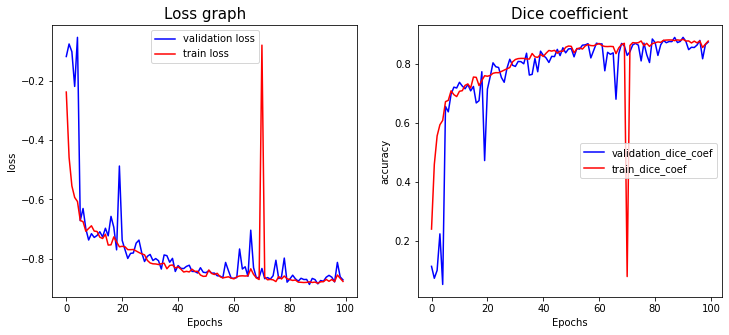

In [33]:
history = history.history

list_traindice = history['dice_coef']
list_valdice = history['val_dice_coef']

list_trainjaccard = history['iou']
list_valjaccard = history['val_iou']

list_trainloss = history['loss']
list_valloss = history['val_loss']

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(list_valloss, 'b-', label='validation loss')
plt.plot(list_trainloss,'r-', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Loss graph', fontsize = 15)
plt.legend(['train', 'val'])
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(list_valdice, 'b-', label= 'validation_dice_coef')
plt.plot(list_traindice, 'r-', label= 'train_dice_coef')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Dice coefficient', fontsize = 15)
plt.legend(['train', 'val'])
plt.legend(loc='best')
plt.show()

In [34]:
from tensorflow.keras.models import Model, load_model, save_model

model = load_model('unet_brain_mri_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

In [35]:
test_gen = train_generator(test, 
                           BATCH_SIZE,
                           dict(),
                           target_size=(im_height, im_width))

results = model.evaluate(test_gen, 
                         steps=len(test) / BATCH_SIZE)

print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 [==============================] - 5s 420ms/step - loss: -0.8959 - binary_accuracy: 0.9979 - iou: 0.8146 - dice_coef: 0.8961
Test lost:  -0.8958922624588013
Test IOU:  0.9979254007339478
Test Dice Coefficent:  0.8145840764045715


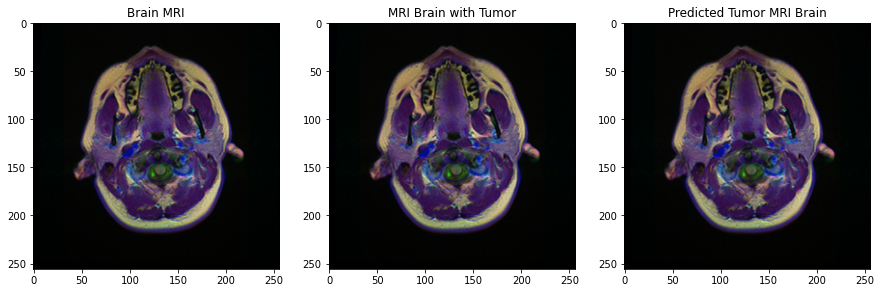

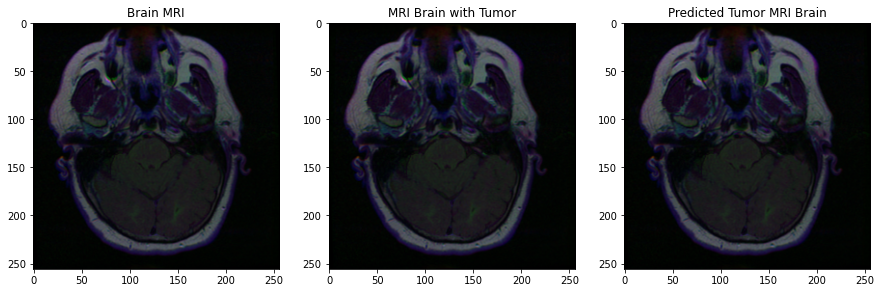

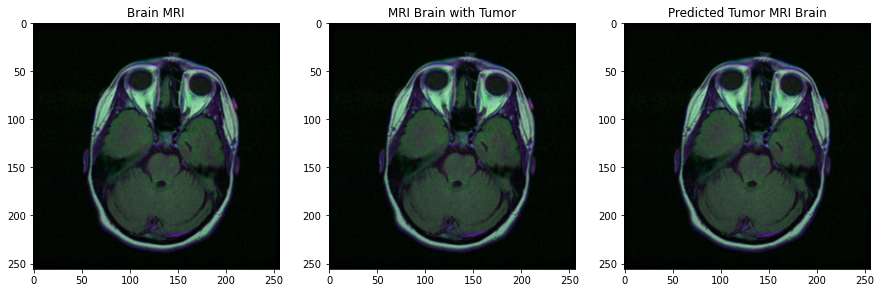

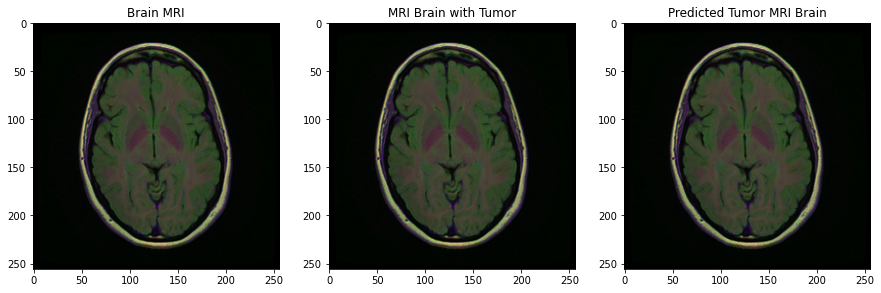

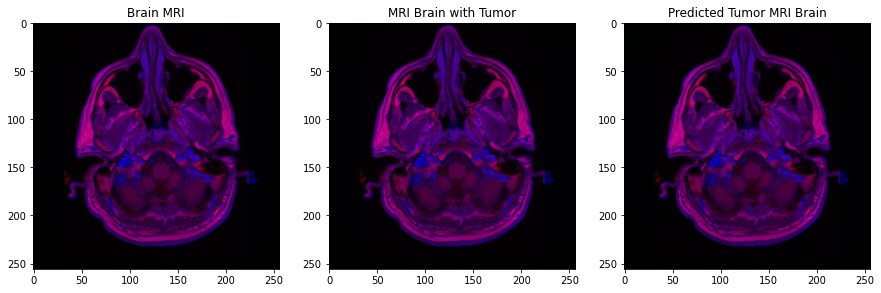

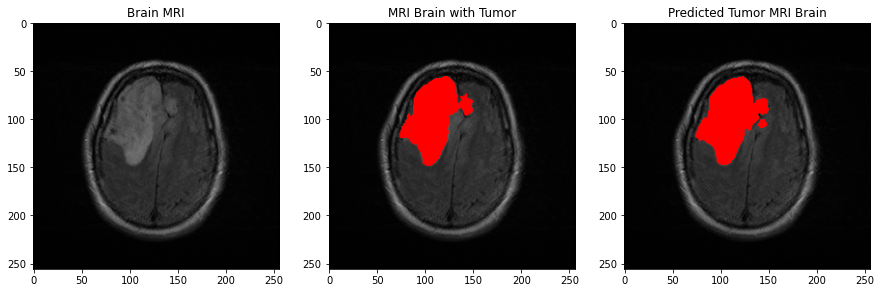

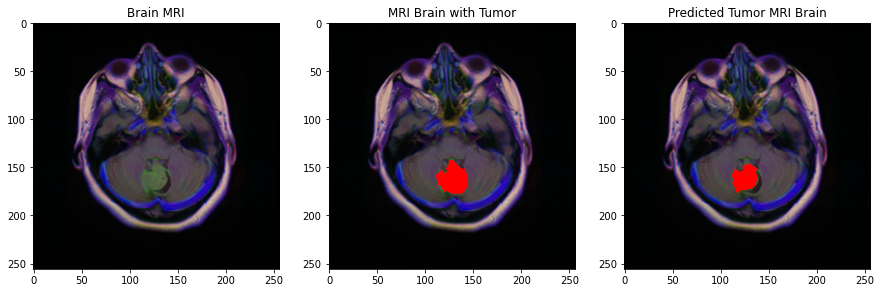

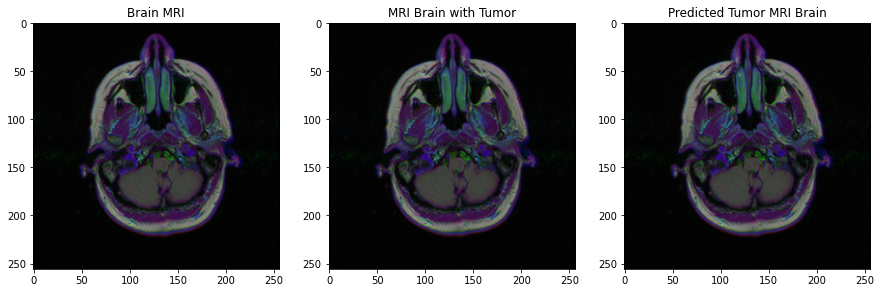

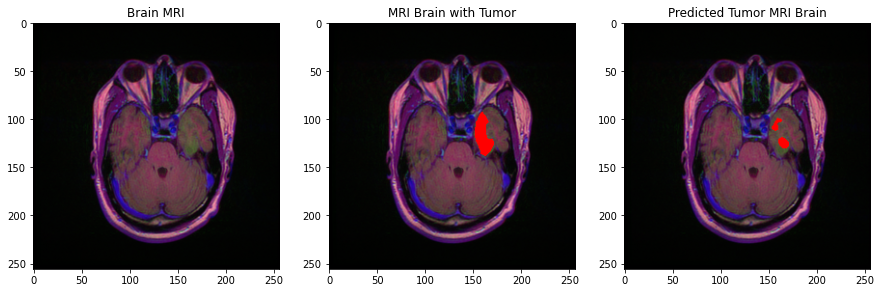

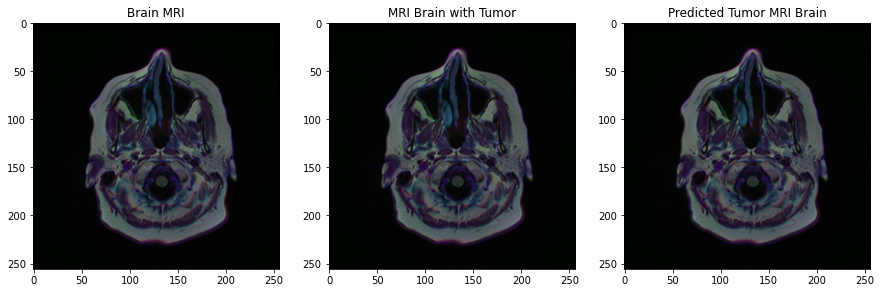

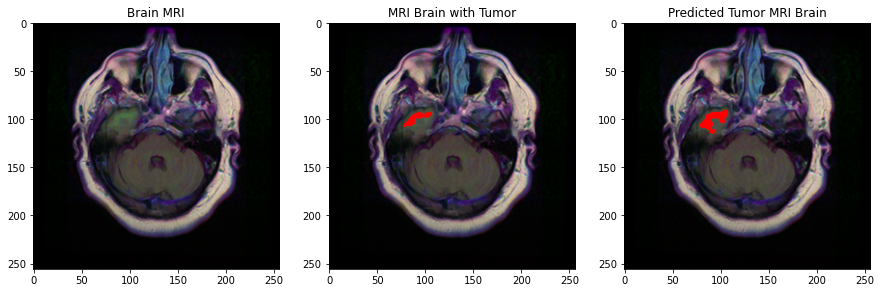

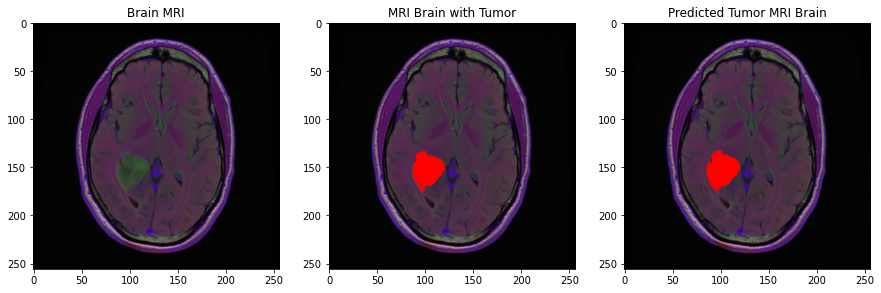

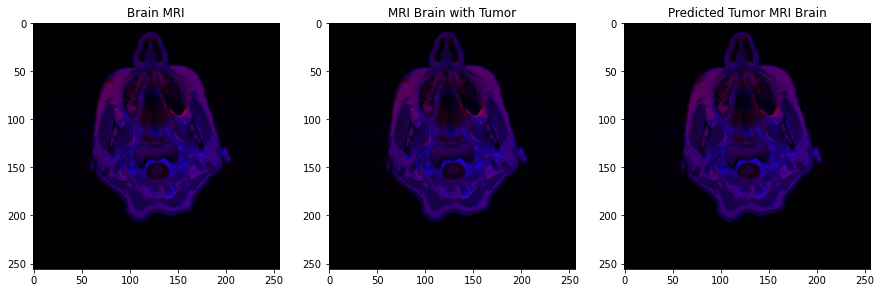

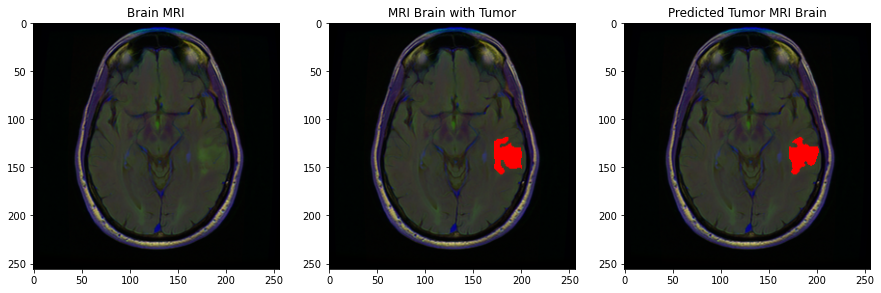

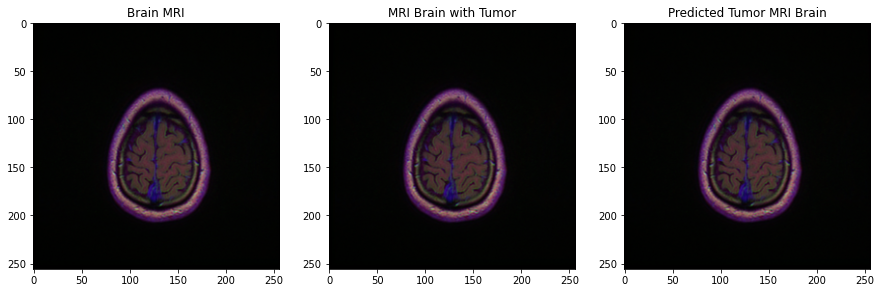

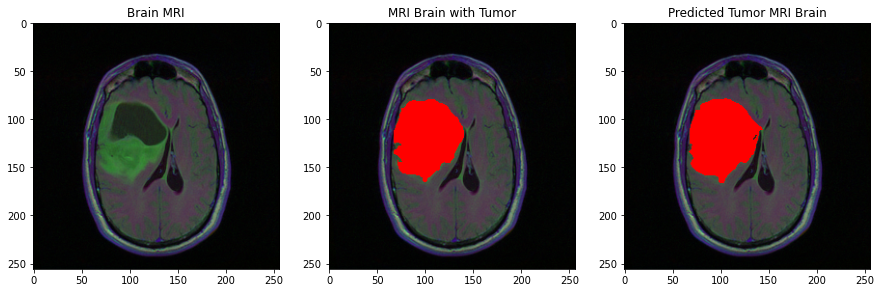

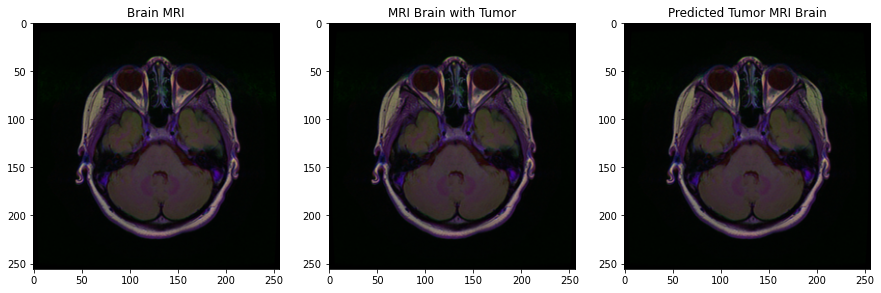

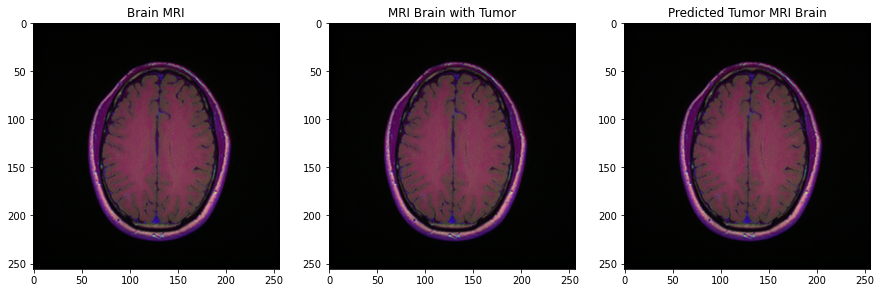

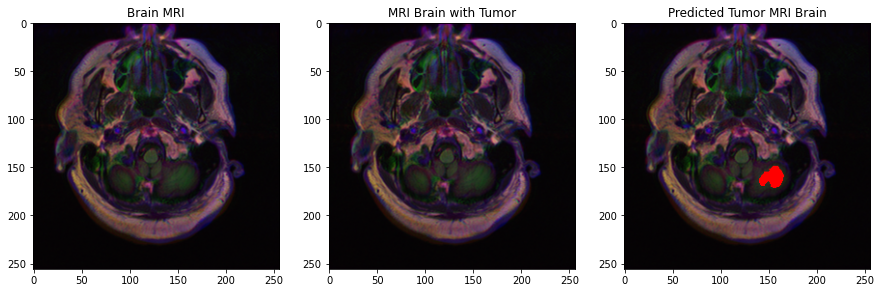

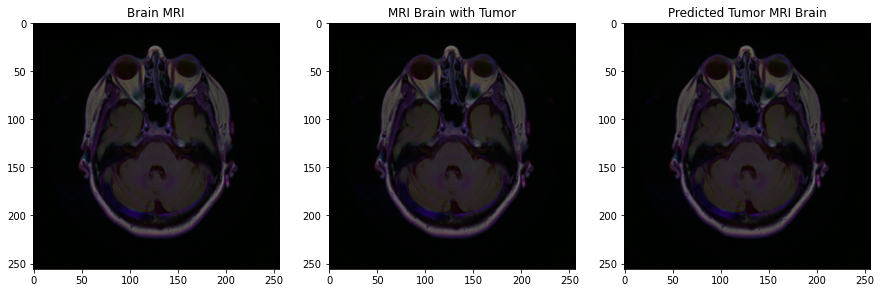

In [36]:
for i in range(1,40,2):
    img_path_test = test.iloc[i, 0]
    msk_path_test = test.iloc[i, 1]
    img = cv2.imread(img_path_test)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    msk= cv2.imread(msk_path_test)
    pred = model.predict(img) 
    img = np.squeeze(img)

    #Plot the Brain MRI scans 
    original = img.copy()
    fig, ax = plt.subplots(1,3, figsize = (15,5))
    ax[0].imshow(original)
    ax[0].set_title("Brain MRI")

    # Plot the Brain MRI scan with their mask
    main = original.copy()
    label = cv2.imread(msk_path_test)
    sample = np.array(np.squeeze(label), dtype = np.uint8)
    contours, hier = cv2.findContours(sample[:,:,0],cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    sample_over_gt = cv2.drawContours(main, contours, -1,[255,0,0], thickness=-1)
    ax[1].imshow(np.squeeze(sample_over_gt))
    ax[1].set_title("MRI Brain with Tumor")
    
    #Plot the predicted mask on the Brain MRI Scan
    main = original.copy()
    sample = np.array(np.squeeze(pred) > 0.5, dtype = np.uint8)
    contours, hier = cv2.findContours(sample,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    sample_over_pr = cv2.drawContours(main, contours, -1, [255,0,0], thickness=-1)
    ax[2].imshow(np.squeeze(sample_over_pr))
    ax[2].set_title("Predicted Tumor MRI Brain")